In [67]:
# Import required modules.
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

%matplotlib inline

## Exploratory Data Analysis

In [2]:
# Read the data into de.
de = pd.read_csv('../data/MIT-BIH_Arrhythmia_Database.csv')

In [3]:
# Show the head of de.
de.head()

,record,type,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
0,101,N,76,313.0,0.074347,-0.160548,1.036401,-0.285662,-0.026824,41,...,0.025930,2,18,22,2,0.025930,0.025930,0.025930,0.025436,0.025436
1,101,N,313,315.0,-0.052079,-0.264784,0.886597,-0.366298,-0.059710,21,...,-0.042009,26,27,62,9,-0.042009,-0.029498,0.005012,0.030892,0.002986
2,101,N,315,321.0,-0.062151,-0.296983,0.991859,-0.410306,-0.065686,22,...,0.009528,3,8,12,1,0.009528,0.009528,0.008786,0.008786,0.008368
3,101,N,321,336.0,-0.063322,-0.281386,1.034903,-0.403880,-0.071750,22,...,-0.020536,6,9,16,1,-0.020536,-0.020257,-0.018965,-0.016968,-0.014555
4,101,N,336,344.0,-0.062915,1.046914,1.046408,1.046408,-0.074639,11,...,0.016053,16,5,31,10,0.016053,0.006742,0.002782,-0.007798,-0.051155


In [4]:
# Show the shape of de.
de.shape

(100689, 34)

In [5]:
# Check for duplicates in de.
de[de.duplicated()].sum()

record              0
type                0
0_pre-RR            0
0_post-RR         0.0
0_pPeak           0.0
0_tPeak           0.0
0_rPeak           0.0
0_sPeak           0.0
0_qPeak           0.0
0_qrs_interval      0
0_pq_interval       0
0_qt_interval       0
0_st_interval       0
0_qrs_morph0      0.0
0_qrs_morph1      0.0
0_qrs_morph2      0.0
0_qrs_morph3      0.0
0_qrs_morph4      0.0
1_pre-RR            0
1_post-RR         0.0
1_pPeak           0.0
1_tPeak           0.0
1_rPeak           0.0
1_sPeak           0.0
1_qPeak           0.0
1_qrs_interval      0
1_pq_interval       0
1_qt_interval       0
1_st_interval       0
1_qrs_morph0      0.0
1_qrs_morph1      0.0
1_qrs_morph2      0.0
1_qrs_morph3      0.0
1_qrs_morph4      0.0
dtype: object

 - No duplicates found

In [6]:
# Check for missing values in de.
de.isnull().sum()

record            0
type              0
0_pre-RR          0
0_post-RR         0
0_pPeak           0
0_tPeak           0
0_rPeak           0
0_sPeak           0
0_qPeak           0
0_qrs_interval    0
0_pq_interval     0
0_qt_interval     0
0_st_interval     0
0_qrs_morph0      0
0_qrs_morph1      0
0_qrs_morph2      0
0_qrs_morph3      0
0_qrs_morph4      0
1_pre-RR          0
1_post-RR         0
1_pPeak           0
1_tPeak           0
1_rPeak           0
1_sPeak           0
1_qPeak           0
1_qrs_interval    0
1_pq_interval     0
1_qt_interval     0
1_st_interval     0
1_qrs_morph0      0
1_qrs_morph1      0
1_qrs_morph2      0
1_qrs_morph3      0
1_qrs_morph4      0
dtype: int64

 - No missing values shown

In [7]:
# Get the statistics of de.
ds = de.describe().round()

In [8]:
# Show statistics of the first 16 columns.
ds.iloc[:, :16]

,record,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,0_pq_interval,0_qt_interval,0_st_interval,0_qrs_morph0,0_qrs_morph1,0_qrs_morph2,0_qrs_morph3
count,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0
mean,174.0,279.0,279.0,0.0,0.0,1.0,-0.0,-0.0,28.0,11.0,60.0,20.0,-0.0,0.0,0.0,1.0
std,52.0,82.0,81.0,0.0,1.0,1.0,1.0,0.0,15.0,9.0,40.0,30.0,0.0,0.0,1.0,1.0
min,100.0,11.0,6.0,-3.0,-2.0,-2.0,-4.0,-4.0,0.0,1.0,5.0,1.0,-4.0,-3.0,-3.0,-3.0
25%,115.0,230.0,230.0,-0.0,-0.0,1.0,-1.0,-0.0,18.0,5.0,33.0,1.0,-0.0,-0.0,-0.0,0.0
50%,203.0,267.0,266.0,0.0,0.0,1.0,-1.0,-0.0,27.0,7.0,46.0,8.0,-0.0,-0.0,0.0,0.0
75%,219.0,324.0,322.0,0.0,1.0,1.0,1.0,-0.0,38.0,16.0,75.0,23.0,-0.0,0.0,1.0,1.0
max,234.0,2114.0,2114.0,4.0,4.0,4.0,4.0,3.0,170.0,150.0,334.0,141.0,3.0,3.0,3.0,3.0


In [9]:
# Show statistics of the last 17 columns.
ds.iloc[:, 17:]

,1_pre-RR,1_post-RR,1_pPeak,1_tPeak,1_rPeak,1_sPeak,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
count,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0
mean,279.0,279.0,0.0,0.0,-0.0,-0.0,-0.0,11.0,10.0,36.0,14.0,-0.0,-0.0,-0.0,-0.0,-0.0
std,82.0,81.0,0.0,0.0,1.0,1.0,0.0,12.0,9.0,17.0,9.0,0.0,0.0,1.0,1.0,1.0
min,11.0,6.0,-2.0,-2.0,-4.0,-6.0,-5.0,0.0,1.0,5.0,1.0,-5.0,-4.0,-4.0,-4.0,-5.0
25%,230.0,230.0,-0.0,0.0,-0.0,-1.0,-1.0,3.0,5.0,25.0,10.0,-1.0,-1.0,-1.0,-1.0,-1.0
50%,267.0,266.0,0.0,0.0,-0.0,-0.0,-0.0,7.0,8.0,33.0,12.0,-0.0,-0.0,-0.0,-0.0,-0.0
75%,324.0,322.0,0.0,1.0,0.0,-0.0,-0.0,18.0,13.0,45.0,17.0,-0.0,-0.0,0.0,0.0,-0.0
max,2114.0,2114.0,5.0,7.0,4.0,3.0,4.0,260.0,185.0,412.0,215.0,4.0,4.0,3.0,4.0,3.0


In [10]:
# Define numerical columns and split into two sets.
col_num = de.drop(columns="type").columns.to_list()
set_one = col_num[:16]
set_two = col_num[17:]

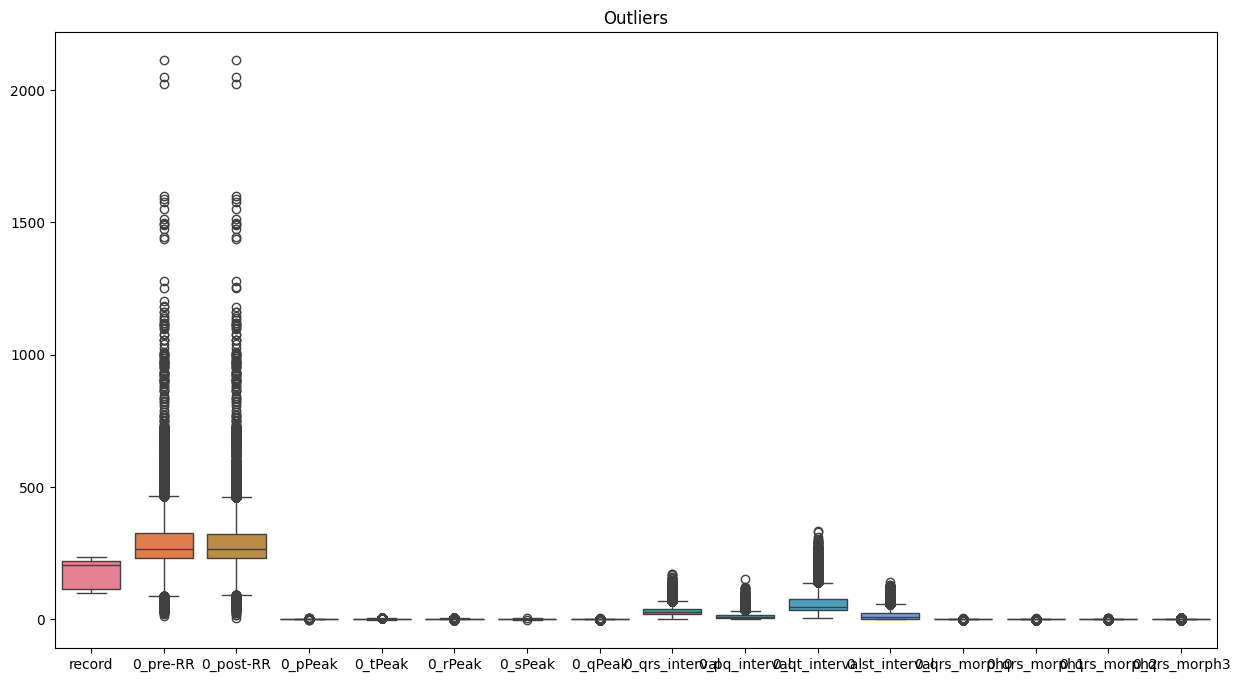

In [11]:
# Draw boxplot of the first set.
plt.figure(figsize=(15, 8))
plt.title('Outliers')
sns.boxplot(data=de[set_one]);

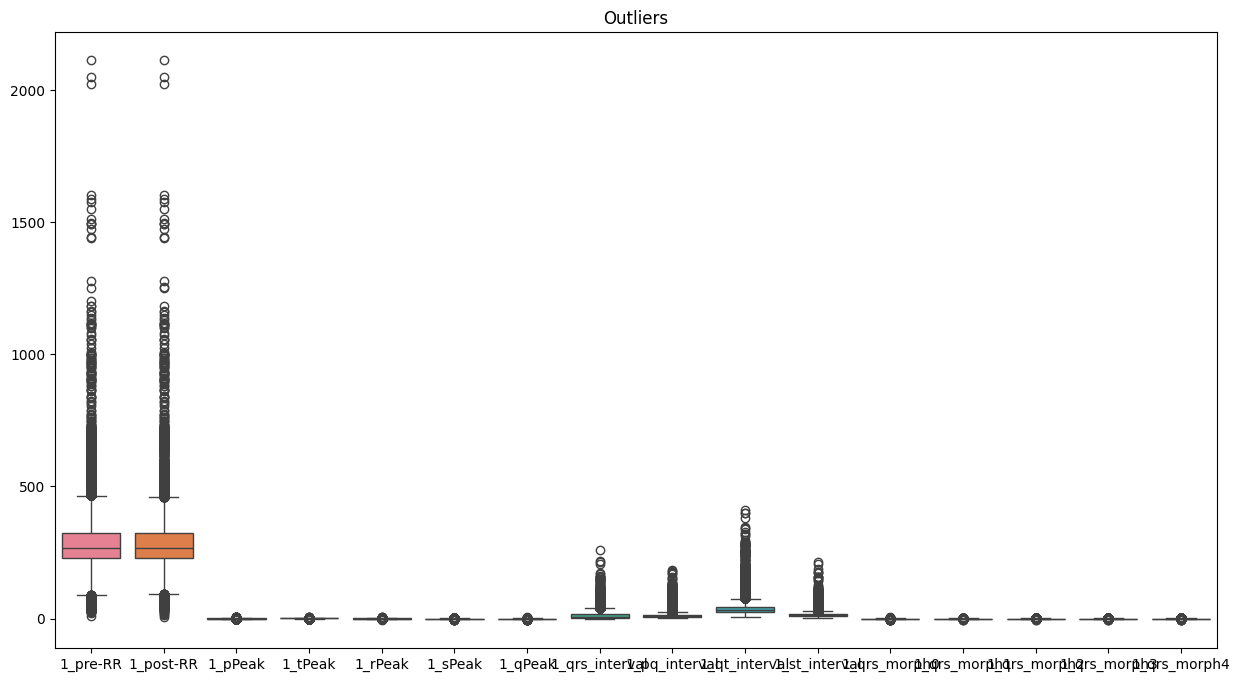

In [12]:
# Draw boxplot of the second set.
plt.figure(figsize=(15, 8))
plt.title('Outliers')
sns.boxplot(data=de[set_two]);

In [13]:
# Check for correletion.
corr = de[col_num].corr().round(2)

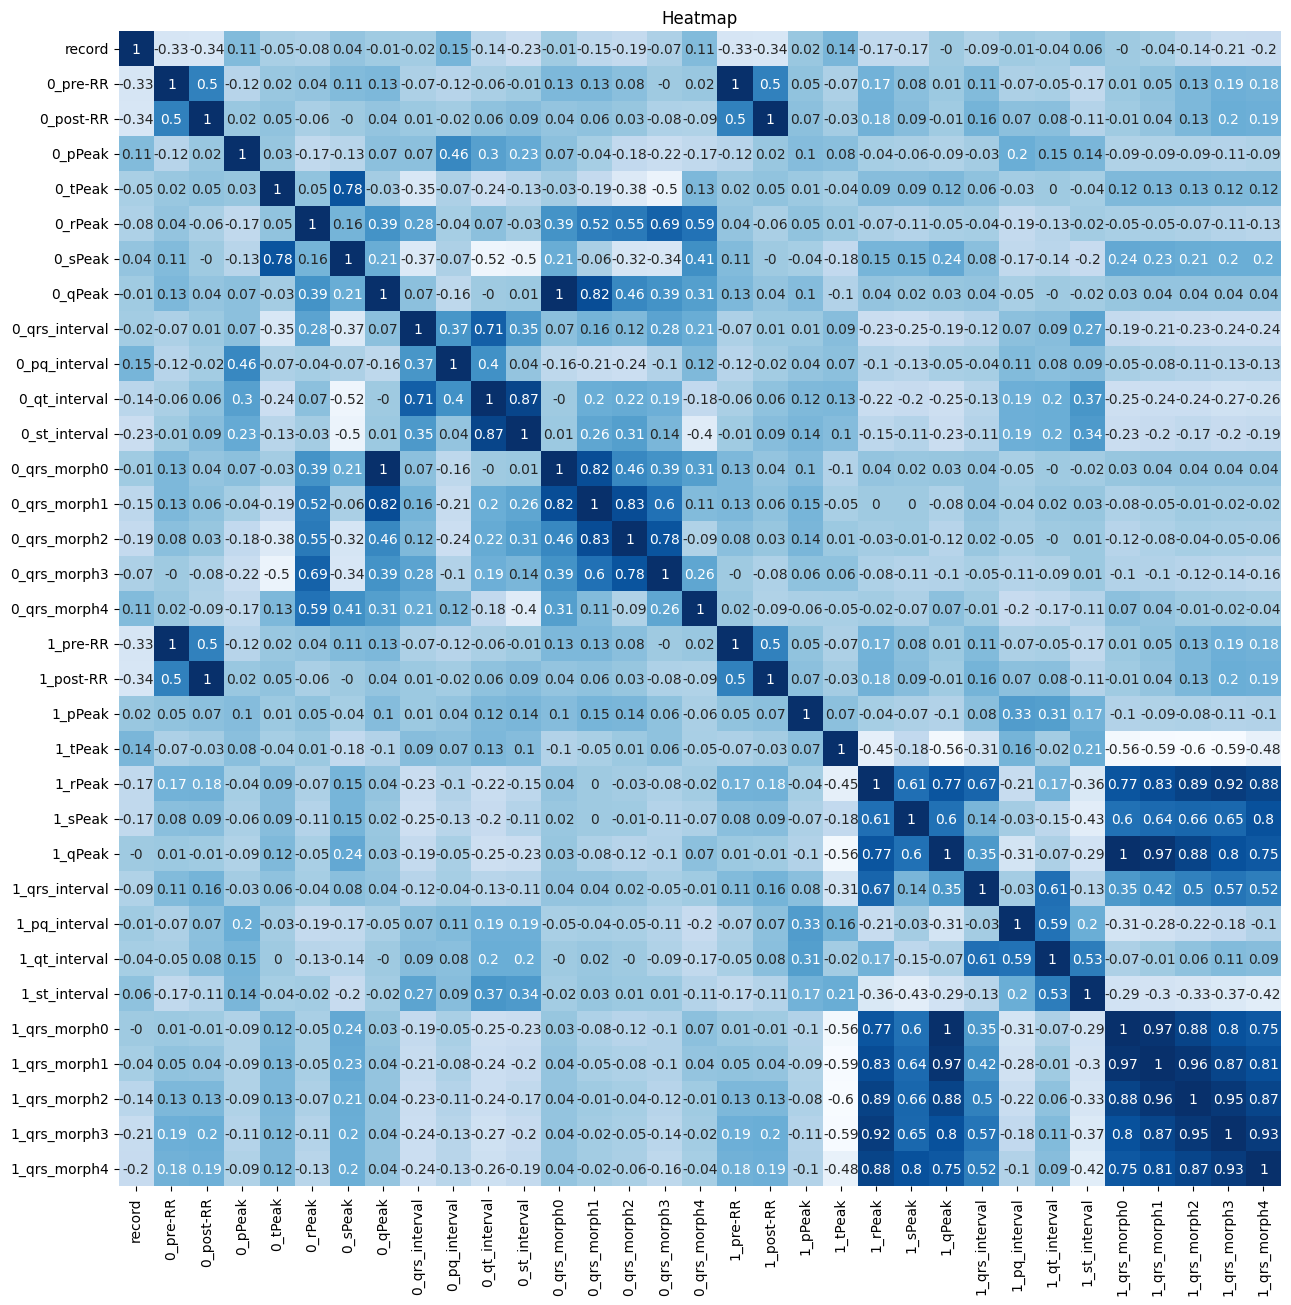

In [14]:
# Draw the correlation heatmap.
plt.figure(figsize=(15, 15))
plt.title('Heatmap')
sns.heatmap(corr, cmap='Blues', annot=True, cbar=False);

In [15]:
# Unstack the correlation values.
du = corr.unstack().sort_values(ascending=False)

In [16]:
# Check the length of df_unstack.
len(du)

1089

In [17]:
# Show the first 40 records of df_unstack.
du[:40]

1_qrs_morph4    1_qrs_morph4      1.0
1_qrs_morph3    1_qrs_morph3      1.0
1_qrs_morph2    1_qrs_morph2      1.0
1_qrs_morph1    1_qrs_morph1      1.0
1_qrs_morph0    1_qrs_morph0      1.0
                1_qPeak           1.0
1_st_interval   1_st_interval     1.0
1_qt_interval   1_qt_interval     1.0
1_pq_interval   1_pq_interval     1.0
1_qrs_interval  1_qrs_interval    1.0
1_qPeak         1_qrs_morph0      1.0
                1_qPeak           1.0
1_sPeak         1_sPeak           1.0
1_rPeak         1_rPeak           1.0
1_tPeak         1_tPeak           1.0
1_pPeak         1_pPeak           1.0
1_post-RR       1_post-RR         1.0
                0_post-RR         1.0
0_pre-RR        0_pre-RR          1.0
1_pre-RR        1_pre-RR          1.0
                0_pre-RR          1.0
0_qrs_morph4    0_qrs_morph4      1.0
0_qrs_morph3    0_qrs_morph3      1.0
0_qrs_morph2    0_qrs_morph2      1.0
0_qrs_morph1    0_qrs_morph1      1.0
0_qrs_morph0    0_qrs_morph0      1.0
            

In [18]:
# Show the next 40 records of df_unstack.
du[41:80]

1_qPeak        1_qrs_morph1     0.97
1_qrs_morph1   1_qrs_morph0     0.97
               1_qPeak          0.97
1_qrs_morph0   1_qrs_morph1     0.97
1_qrs_morph2   1_qrs_morph1     0.96
1_qrs_morph1   1_qrs_morph2     0.96
1_qrs_morph2   1_qrs_morph3     0.95
1_qrs_morph3   1_qrs_morph2     0.95
               1_qrs_morph4     0.93
1_qrs_morph4   1_qrs_morph3     0.93
1_rPeak        1_qrs_morph3     0.92
1_qrs_morph3   1_rPeak          0.92
1_rPeak        1_qrs_morph2     0.89
1_qrs_morph2   1_rPeak          0.89
               1_qPeak          0.88
1_qrs_morph0   1_qrs_morph2     0.88
1_rPeak        1_qrs_morph4     0.88
1_qrs_morph2   1_qrs_morph0     0.88
1_qPeak        1_qrs_morph2     0.88
1_qrs_morph4   1_rPeak          0.88
               1_qrs_morph2     0.87
1_qrs_morph3   1_qrs_morph1     0.87
0_qt_interval  0_st_interval    0.87
1_qrs_morph2   1_qrs_morph4     0.87
0_st_interval  0_qt_interval    0.87
1_qrs_morph1   1_qrs_morph3     0.87
               1_rPeak          0.83
1

In [19]:
# List the highly correlated columns.
remove_corr = ['1_qrs_morph0', '1_qrs_morph1', '1_qrs_morph2', '1_qrs_morph3', '1_qrs_morph4']

In [20]:
# Remove the highly correlated columns.
de = de.drop(columns=remove_corr)

In [21]:
# Show the shape of de.
de.shape

(100689, 29)

In [22]:
# Check the value counts of the target column.
de.type.value_counts()

type
N       90083
VEB      7009
SVEB     2779
F         803
Q          15
Name: count, dtype: int64

 - N represents normal while VEB, SVEB, F, and Q represents arrhythmia

In [23]:
# Transform multi-class labels into binary-class (1 and 0).
de['type'] = de.type.map({'N': 0, 'VEB': 1, 'SVEB': 1, 'F': 1, 'Q': 1})

In [24]:
# Check the value counts of the target column.
de.type.value_counts()

type
0    90083
1    10606
Name: count, dtype: int64

In [25]:
# Show the head of de.
de.head()

,record,type,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,...,1_post-RR,1_pPeak,1_tPeak,1_rPeak,1_sPeak,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval
0,101,0,76,313.0,0.074347,-0.160548,1.036401,-0.285662,-0.026824,41,...,313.0,0.038310,0.025784,0.025930,0.025271,0.025930,2,18,22,2
1,101,0,313,315.0,-0.052079,-0.264784,0.886597,-0.366298,-0.059710,21,...,315.0,0.014264,0.045458,0.032573,-0.104503,-0.042009,26,27,62,9
2,101,0,315,321.0,-0.062151,-0.296983,0.991859,-0.410306,-0.065686,22,...,321.0,0.021311,0.008246,0.009528,0.008230,0.009528,3,8,12,1
3,101,0,321,336.0,-0.063322,-0.281386,1.034903,-0.403880,-0.071750,22,...,336.0,-0.000665,-0.009725,-0.010203,-0.010203,-0.020536,6,9,16,1
4,101,0,336,344.0,-0.062915,1.046914,1.046408,1.046408,-0.074639,11,...,344.0,0.024559,0.016925,0.016053,-0.099918,0.016053,16,5,31,10


In [26]:
#  Create a function to split the data.
def split_data(df):
    
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

    df_full_train = df_full_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)

    y_full_train = df_full_train['type'].values
    y_test = df_test.type.values
    y_train = df_train.type.values
    y_val = df_val.type.values

    del df_full_train['type']
    del df_test['type']
    del df_train['type']
    del df_val['type']
    
    dv = DictVectorizer(sparse=False)

    full_train_dicts = df_full_train.to_dict(orient='records')
    test_dicts = df_test.to_dict(orient='records')
    train_dicts = df_train.to_dict(orient='records')
    val_dicts = df_val.to_dict(orient='records')
    
    X_full_train = dv.fit_transform(full_train_dicts)
    X_test = dv.transform(test_dicts)    
    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    return  X_full_train, X_test, X_train, X_val, y_full_train, y_test, y_train, y_val, dv

In [27]:
# Create function to train the model.
def train_model(alg):
    _, _, X_train, X_val, _, _, y_train, y_val, _ = split_data(df)
    model = alg.fit(X_train, y_train)
    
    return model, X_val, y_val

In [28]:
# Create function to predict probability.
def predict_pro(model, X_val, y_val):
    y_pred = model.predict_proba(X_val)[:, 1]
    score = round(roc_auc_score(y_val, y_pred), 4)

    return score, y_pred

## Logistic Regression

### Train Model

In [29]:
# Copy the data to be used.
df = de.copy()

In [30]:
# Define the algorithm.
alg_lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=22)

In [31]:
# Train the model.
mod_lr, X_val, y_val = train_model(alg_lr)

In [32]:
# Calculate the probability ROC AUC score.
score_lr, y_pred = predict_pro(mod_lr, X_val, y_val)
print(f'score_lr = {round(score_lr, 4)}')

score_lr = 0.9528


In [101]:
# Define ROC curve plot function.
def roc_curve_draw(y_val, y_pred):
    plt.figure(figsize=(5, 5))
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    plt.plot(fpr, tpr, label='probability')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

    plt.title('ROC Curve')
    plt.legend()
    
    return plt.show()    

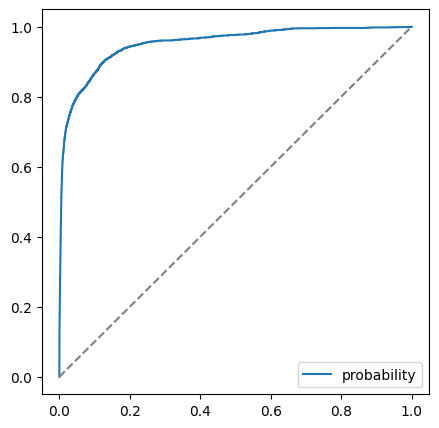

In [33]:
# Plot the ROC curve.
roc_curve_draw(y_val, y_pred)

### Confusion Matrix

In [34]:
# Define the confusion_matrix_dataframe function.
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [35]:
# Show the confusion matrix.
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,2124,18014,0,0
10,0.1,1886,2074,238,15940
20,0.2,1678,802,446,17212
30,0.3,1559,452,565,17562
40,0.4,1458,282,666,17732
50,0.5,1364,208,760,17806
60,0.6,1284,155,840,17859
70,0.7,1150,118,974,17896
80,0.8,978,89,1146,17925
90,0.9,693,51,1431,17963


### Precision and Recall

In [99]:
# Define the precision-recall plot function.
def pre_rec_plot(df_scores):
    # Calculate the precision and recall.
    df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)  
    
    # Plot the curves.
    plt.plot(df_scores.threshold, df_scores.p, label='precision')
    plt.plot(df_scores.threshold, df_scores.r, label='recall')

    plt.title('Precision-Recall Curves')
    plt.legend()
    
    return plt.show()

In [ ]:
# Plot the precision and recall curves.
pre_rec_plot(df_scores)

### F1 Score

In [38]:
# Get the F1 scores.
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [40]:
# Get the maximum f1-score.
f1_max_lr = df_scores['f1'].max()
print(f'f1_max_lr = {round(f1_max_lr, 4)}')

f1_max_lr = 0.759


In [104]:
# Define the f1 plot function.
def f1_plot(df_scores):
    plt.plot(df_scores.threshold, df_scores.f1)
    plt.xticks(np.linspace(0, 1, 11))
    plt.title('F1 Curve')
    
    return plt.show()

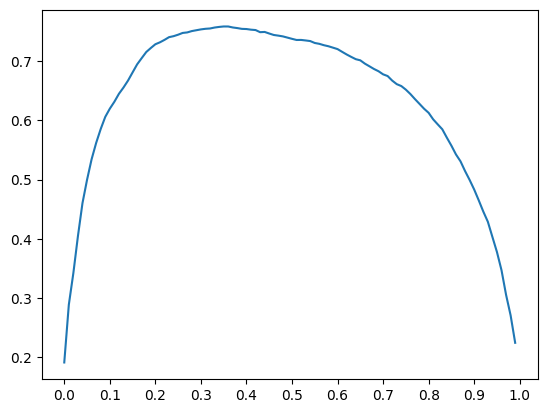

In [39]:
# Plot the F1 scores.
f1_plot(df_scores)

## Random Forest Classifier

### Train Model

In [81]:
# Copy the data to be used.
df = de.copy()

In [82]:
# Define the algorithm.
alg_rf = RandomForestClassifier(n_estimators=100, random_state=22, n_jobs=-1)

In [83]:
# Train the model.
mod_rf, X_val, y_val = train_model(alg_rf)

In [84]:
# Calculate the probability ROC AUC score.
score_rf, y_pred = predict_pro(mod_rf, X_val, y_val)
print(f'score_rf = {round(score_rf, 4)}')

score_rf = 0.9986


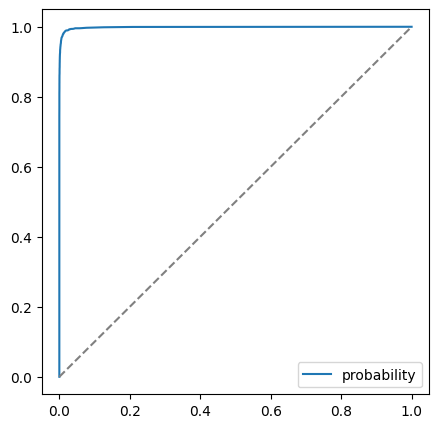

In [85]:
# Plot the ROC curve.
roc_curve_draw(y_val, y_pred)

### Confusion Matrix

In [86]:
# Show the confusion matrix.
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,2124,18014,0,0
10,0.1,2111,655,13,17359
20,0.2,2098,307,26,17707
30,0.3,2068,159,56,17855
40,0.4,2041,91,83,17923
50,0.5,2003,54,121,17960
60,0.6,1930,24,194,17990
70,0.7,1849,12,275,18002
80,0.8,1755,5,369,18009
90,0.9,1529,0,595,18014


### Precision and Recall

In [48]:
# Calculate the precision and recall.
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

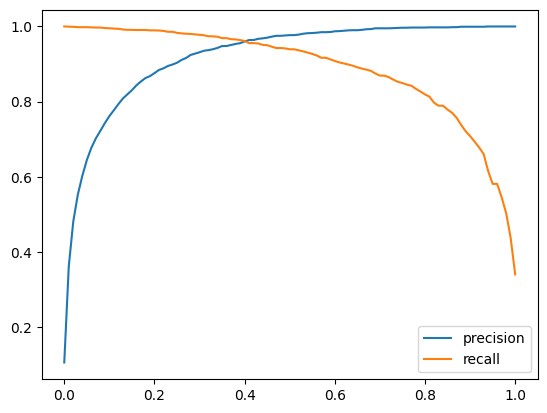

In [49]:
# Plot the curves.
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.legend()
plt.show()

### F1 Score

In [102]:
# Get the F1 scores.
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [52]:
# Get the maximum f1-score.
f1_max_rf = df_scores['f1'].max()
print(f'f1_max_rf = {round(f1_max_rf, 4)}')

f1_max_rf = 0.9609


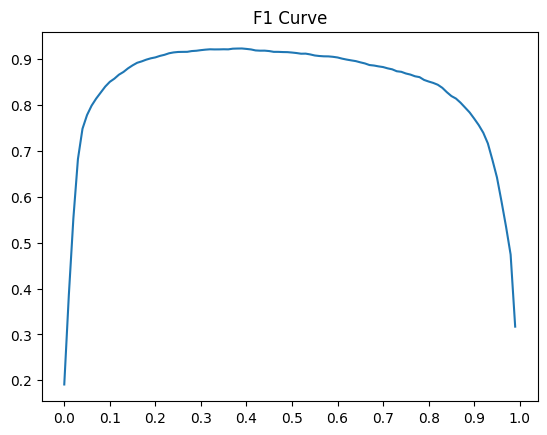

In [105]:
# Draw the F1 scores.
f1_draw(df_scores)

### Gradient Boosting Classifier

In [87]:
# Copy the data to be used.
df = de.copy()

In [88]:
# Define the algorithm.
alg_gb = GradientBoostingClassifier(n_estimators=100, random_state=22)

In [89]:
# Train the model.
mod_gb, X_val, y_val = train_model(alg_gb)

In [90]:
# Calculate the probability ROC AUC score.
score_gb, y_pred = predict_pro(mod_gb, X_val, y_val)
print(f'score_gb = {round(score_gb, 4)}')

score_gb = 0.994


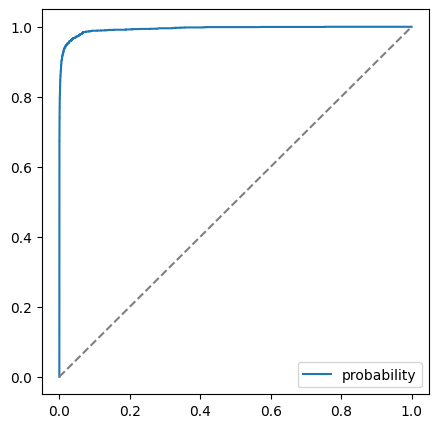

In [94]:
# Show the ROC curve.
roc_curve_draw(y_val, y_pred)

### Confusion Matrix

In [92]:
# Show the confusion matrix.
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,2124,18014,0,0
10,0.1,2048,642,76,17372
20,0.2,2000,300,124,17714
30,0.3,1954,170,170,17844
40,0.4,1908,104,216,17910
50,0.5,1845,65,279,17949
60,0.6,1789,45,335,17969
70,0.7,1699,25,425,17989
80,0.8,1586,15,538,17999
90,0.9,1334,4,790,18010


### Precision and Recall

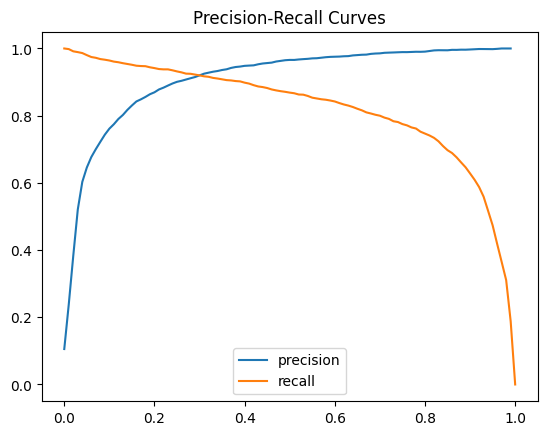

In [100]:
# Plot the precision and recall curves.
pre_rec_plot(df_scores)

### F1 Score

In [107]:
# Get the F1 scores.
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [108]:
# Get the maximum f1-score.
f1_max_rf = df_scores['f1'].max()
print(f'f1_max_rf = {round(f1_max_rf, 4)}')

f1_max_rf = 0.9236


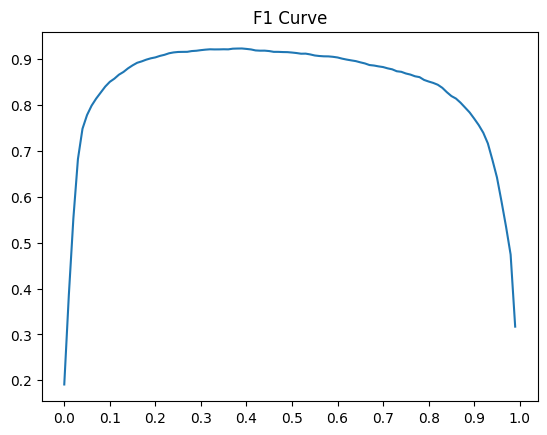

In [109]:
# Draw the F1 scores.
f1_draw(df_scores)

### XGB Classifier

In [53]:
# Copy the data to be used.
df = de.copy()

In [54]:
# Define a function to create dtrain and dval.
def get_xgb_dicts(df):
    # Split the data.
    _, _, X_train, X_val, _, _, y_train, y_val, dv = split_data(df)

    # Create the features.
    features = dv.feature_names_
    regex = re.compile(r"<", re.IGNORECASE)
    features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

    # Create the DMatrix.
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
    dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

    return dtrain, dval

In [55]:
# Get dtrain and dval.
dtrain, dval = get_xgb_dicts(df)

In [56]:
# Define the parameters.
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [57]:
# Train the model.
mod_xgb = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [58]:
# Calculate the probability ROC AUC score.
y_pred = mod_xgb.predict(dval)
score_xgb = round(roc_auc_score(y_val, y_pred), 4)
print(f'score_xgb = {score_xgb}')

score_xgb = 0.9952


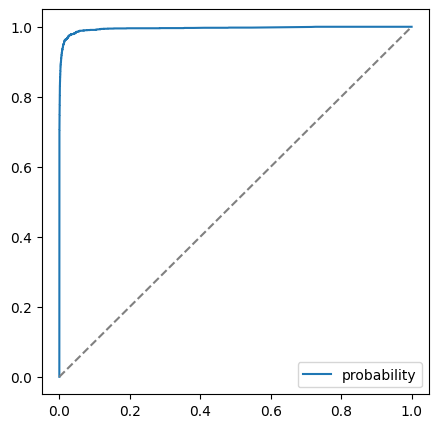

In [59]:
# Plot the ROC curve.
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr, label='probability')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

### Confusion Matrix

In [61]:
# Show the confusion matrix.
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,2124,18014,0,0
10,0.1,2072,530,52,17484
20,0.2,2021,231,103,17783
30,0.3,1971,133,153,17881
40,0.4,1933,95,191,17919
50,0.5,1897,69,227,17945
60,0.6,1855,52,269,17962
70,0.7,1811,40,313,17974
80,0.8,1728,26,396,17988
90,0.9,1482,4,642,18010


### Precision and Recall

In [62]:
# Calculate the precision and recall.
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

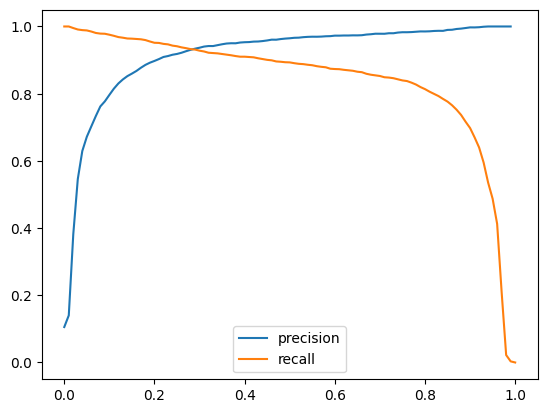

In [63]:
# Plot the curves.
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.legend()
plt.show()

### F1 Score

In [64]:
# Get the F1 scores.
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

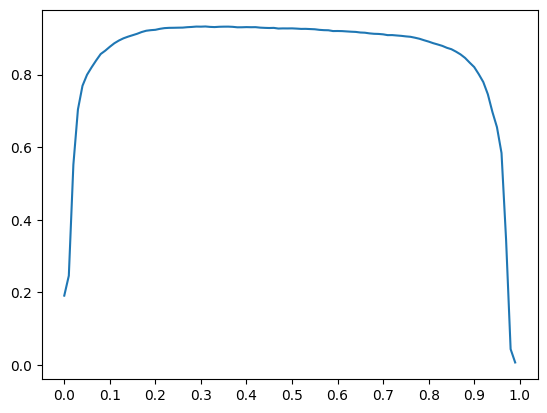

In [65]:
# Plot the F1 scores.
plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

In [66]:
# Get the maximum f1-score.
f1_max_xgb = df_scores['f1'].max()
print(f'f1_max_xgb = {round(f1_max_xgb, 4)}')

f1_max_xgb = 0.9329


## Feature Importances

### Logistic Regression

In [ ]:
# Copy the data to be used.
df = de.copy()

In [ ]:
# Split the data.
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

In [ ]:
# Apply the feature elimination technique.
original_score = score_lr
scores = pd.DataFrame(columns=['eliminated_feature', 'score_lr', 'difference'])
features = df_train.drop(columns='type').columns.to_list()

for feature in tqdm(features):
    subset = features.copy()
    subset.remove(feature)

    y_train = df_train.type.values
    y_val = df_val.type.values
    
    dv = DictVectorizer(sparse=False)
    train_dicts = df_train[subset].to_dict(orient='records')
    val_dicts = df_val[subset].to_dict(orient='records')

    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=22)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    score = roc_auc_score(y_val, y_pred)
    
    scores.loc[len(scores)] = [feature, score, original_score - score]

In [ ]:
# Print the scores.
scores['difference'] = [abs(x) for x in scores['difference']]
scores.sort_values(by='difference', axis=0, ascending=False).iloc[:10,:]

### Random Forest Classifier

In [ ]:
# Copy the data to be used.
df = de.copy()

In [ ]:
# Split the data.
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

In [ ]:
# Apply the feature elimination technique.
original_score = score_rf
scores = pd.DataFrame(columns=['eliminated_feature', 'score_rf', 'difference'])
features = df_train.drop(columns='type').columns.to_list()

for feature in tqdm(features):
    subset = features.copy()
    subset.remove(feature)

    y_train = df_train.type.values
    y_val = df_val.type.values

    dv = DictVectorizer(sparse=False)
    train_dicts = df_train[subset].to_dict(orient='records')
    val_dicts = df_val[subset].to_dict(orient='records')

    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    model = RandomForestClassifier(n_estimators=100, random_state=22, n_jobs=-1)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    score = roc_auc_score(y_val, y_pred)
    
    scores.loc[len(scores)] = [feature, score, original_score - score]

In [ ]:
# Print the scores.
scores['difference'] = [abs(x) for x in scores['difference']]
scores.sort_values(by='difference', axis=0, ascending=False).iloc[:10,:]

### XGB Classifier

In [ ]:
# Copy the data to be used.
df = de.copy()

In [ ]:
# Split the data.
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

In [ ]:
# Apply the feature elimination technique.
original_score = score_xgb
scores = pd.DataFrame(columns=['eliminated_feature', 'score_xgb', 'difference'])
features = df_train.drop(columns='type').columns.to_list()

for feature in tqdm(features):
    subset = features.copy()
    subset.remove(feature)

    y_train = df_train.type.values
    y_val = df_val.type.values

    dv = DictVectorizer(sparse=False)
    train_dicts = df_train[subset].to_dict(orient='records')
    val_dicts = df_val[subset].to_dict(orient='records')

    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)
    
    features_x = dv.feature_names_
    regex = re.compile(r"<", re.IGNORECASE)
    features_x = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features_x]
    
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features_x)
    dval = xgb.DMatrix(X_val, label=y_val, feature_names=features_x)
    
    xgb_params = {
        'eta': 0.3, 
        'max_depth': 6,
        'min_child_weight': 1,
        
        'objective': 'binary:logistic',
        'nthread': 8,
        
        'seed': 1,
        'verbosity': 1,
    }

    mod_xgb = xgb.train(xgb_params, dtrain, num_boost_round=10)

    y_pred = mod_xgb.predict(dval)
    score = roc_auc_score(y_val, y_pred)
    
    scores.loc[len(scores)] = [feature, score, original_score - score]

In [ ]:
# Print the scores.
scores['difference'] = [abs(x) for x in scores['difference']]
scores.sort_values(by='difference', axis=0, ascending=False).iloc[:10,:]

## Model Tuning

### Logistic Regression

In [ ]:
# Copy the data to be used.
df = de.copy()

In [ ]:
columns = df.drop(columns='type').columns.to_list()

In [ ]:
# Split the data.
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

In [ ]:
# Create function to train the kfold.
def train_kfold(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer()
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [ ]:
# Create function to predict the kfold.
def predict_kfold(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=22)

the_scores = []

for C in tqdm([x / 40.0 for x in range(16, 33, 1)]):

    scores = []

    for train_idx, val_idx in kfold.split(df_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['type'].values
        y_val = df_val['type'].values

        dv, model = train_kfold(df_train, y_train, C=C)
        y_pred = predict_kfold(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    the_scores.append((C, np.mean(scores)))

df_scores_lr = pd.DataFrame(the_scores, columns=['C', 'score_lr'])

In [ ]:
# Get the maximum score.
max_score_lr = df_scores_lr.score_lr.max()
print(f'max_score_lr = {max_score_lr}')

In [ ]:
# Get the index of max_score_lr .
index_lr = df_scores_lr.index[df_scores_lr.score_lr==max_score_lr].tolist()[0]
print(f'index_lr = {index_lr}')

In [ ]:
# Find the C in index index_lr.
C_max = df_scores_lr.C[index_lr]
print(f'C_max = {C_max}')

In [ ]:
# Plot df_scores_lr.
plt.plot(df_scores_lr.C, df_scores_lr.score_lr)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.show()

 - The best C is 0.6

### Random Forest Classifier

#### For n_estimators

In [ ]:
# Copy the data to be used.
df = de.copy()

In [ ]:
# Split the data.
_, _, X_train, X_val, _, _, y_train, y_val, _ = split_data(df)

In [ ]:
# Find the best maximum n_estimators.
scores = []

for n in tqdm(range(100, 201, 5)):
    rf = RandomForestClassifier(n_estimators=n, random_state=22, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    
    scores.append((n, score))

df_scores_rf_n = pd.DataFrame(scores, columns=['n_estimators', 'score_rf_n'])

In [ ]:
# Get the maximum score.
max_score_rf_n = df_scores_rf_n.score_rf_n.max()
print(f'max_score_rf_n = {max_score_rf_n}')

In [ ]:
# Get the index of max_score_rf_n.
index_rf_n = df_scores_rf_n.index[df_scores_rf_n.score_rf_n==max_score_rf_n].tolist()[0]
print(f'index_rf_n = {index_rf_n}')

In [ ]:
# Find the n in index index_rf_n .
n_max_rf = df_scores_rf_n.n_estimators[index_rf_n]
print(f'n_max_rf = {n_max_rf}')

In [ ]:
# Plot df_scores_rf.
plt.plot(df_scores_rf_n.n_estimators, df_scores_rf_n.score_rf_n)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.show();

#### For max_depth

In [ ]:
# Copy the data to be used.
df = de.copy()

In [ ]:
# Split the data.
_, _, X_train, X_val, _, _, y_train, y_val, _ = split_data(df)

In [ ]:
# Find the best maximum depth.
scores = []

for d in tqdm([30, 40, 50, 60]):
    rf = RandomForestClassifier(n_estimators=0,
                               max_depth=d,
                               random_state=22, 
                               n_jobs=-1)

    for n in tqdm(range(100, 201, 5)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, y_pred)

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'score_rf_d']
df_scores_rf_d = pd.DataFrame(scores, columns=columns)

In [ ]:
# Get the maximum score.
max_score_rf_d = df_scores_rf_d.score_rf_d.max()
print(f'max_score_rf_d = {max_score_rf_d}')

In [ ]:
# Get the index of max_score_rf_n.
index_rf_d = df_scores_rf_d.index[df_scores_rf_d.score_rf_d==max_score_rf_d].tolist()[0]
print(f'index_rf_d = {index_rf_d}')

In [ ]:
# Find the d in index index_rf_n .
d_max_rf = df_scores_rf_d.max_depth[index_rf_d]
print(f'd_max_rf = {d_max_rf}')

In [ ]:
# Find the n in index index_rf_n .
n_max_rf = df_scores_rf_d.n_estimators[index_rf_d]
print(f'n_max_rf = {n_max_rf}')

In [ ]:
# Plot the RMSE scores.
for d in [30, 40, 50, 60]:
    df_subset = df_scores_rf_d[df_scores_rf_d.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.score_rf_d, label=d)

plt.xlabel('n_estimators')
plt.ylabel('score')
plt.legend()
plt.show()

### XGB Classifier

In [ ]:
# Copy the data to be used.
df = de.copy()

In [ ]:
# Define a function to parse the output.
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    
    return df_results

In [ ]:
# Get dtrain and dval.
dtrain, dval = get_xgb_dicts(df)

In [ ]:
# Initialize the process.
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [ ]:
# Store values for 'eta=0.3'.
scores['eta=0.1'] = parse_xgb_output(output)

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [ ]:
# Store values for 'eta=0.1'.
scores['eta=0.3'] = parse_xgb_output(output)

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.5, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [ ]:
# Store values for 'eta=0.1'.
scores['eta=0.5'] = parse_xgb_output(output)

In [ ]:
# Inspect the results.
#plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc, label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc, label='0.3')
plt.plot(scores['eta=0.5'].num_iter, scores['eta=0.3'].val_auc, label='0.5')
plt.legend()
plt.show()

In [ ]:
# Inspect the results.
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc, label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc, label='0.3')
plt.plot(scores['eta=0.5'].num_iter, scores['eta=0.3'].val_auc, label='0.5')
plt.legend()
plt.show()

## Running Time

In [ ]:
Logistic Regression